In [1]:
import re
import sys
from time import time, sleep
from pprint import pprint
from functools import partial
from multiprocessing import Pool

import numpy as np
import pandas as pd
import optuna
import matplotlib.pyplot as plt

FILENAME = "main.cpp"

In [2]:
!cp ../answer/main.cpp ./{FILENAME}

In [3]:
#!g++ {FILENAME} -std=gnu++17 -Wall -Wextra -O2 -DONLINE_JUDGE -o {FILENAME}.out
!g++ {FILENAME} -std=gnu++17 -Wall -Wextra -O2 -o {FILENAME}.out

main.cpp:49: warning: ignoring #pragma clang attribute [-Wunknown-pragmas]
   49 | #pragma clang attribute push (__attribute__((target("arch=skylake"))),apply_to=function)
      | 
main.cpp:1288: warning: ignoring #pragma clang attribute [-Wunknown-pragmas]
 1288 | #pragma clang attribute pop
      | 
main.cpp: In function ‘void Solve()’:
main.cpp:1196:72: warning: missing initializer for member ‘Solve()::Node::action’ [-Wmissing-field-initializers]
 1196 |   node_buffer.push({ state_buffer[0].score, nullptr, &state_buffer[0] });
      |                                                                        ^
main.cpp: In instantiation of ‘HashMap<T, size, KeyType>::HashMap() [with T = double; int size = 1048576; KeyType = long long unsigned int]’:
main.cpp:535:26:   required from here
main.cpp:477:30: warning: suggest parentheses around ‘-’ in operand of ‘&’ [-Wparentheses]
  477 |   static_assert((size & size - 1) == 0, "not pow of 2");
      |                         ~~~~~^~~
main.c

In [4]:
# テストケース生成
SEED = 1000
N_TESTCASES = 200

!mkdir in
for i in range(N_TESTCASES):
    filename = f"{i:04d}.txt"
    seed = SEED + i
    !python3 ../A/tester/generator.py {seed} > ./in/{filename}
!ls in

0000.txt  0025.txt  0050.txt  0075.txt	0100.txt  0125.txt  0150.txt  0175.txt
0001.txt  0026.txt  0051.txt  0076.txt	0101.txt  0126.txt  0151.txt  0176.txt
0002.txt  0027.txt  0052.txt  0077.txt	0102.txt  0127.txt  0152.txt  0177.txt
0003.txt  0028.txt  0053.txt  0078.txt	0103.txt  0128.txt  0153.txt  0178.txt
0004.txt  0029.txt  0054.txt  0079.txt	0104.txt  0129.txt  0154.txt  0179.txt
0005.txt  0030.txt  0055.txt  0080.txt	0105.txt  0130.txt  0155.txt  0180.txt
0006.txt  0031.txt  0056.txt  0081.txt	0106.txt  0131.txt  0156.txt  0181.txt
0007.txt  0032.txt  0057.txt  0082.txt	0107.txt  0132.txt  0157.txt  0182.txt
0008.txt  0033.txt  0058.txt  0083.txt	0108.txt  0133.txt  0158.txt  0183.txt
0009.txt  0034.txt  0059.txt  0084.txt	0109.txt  0134.txt  0159.txt  0184.txt
0010.txt  0035.txt  0060.txt  0085.txt	0110.txt  0135.txt  0160.txt  0185.txt
0011.txt  0036.txt  0061.txt  0086.txt	0111.txt  0136.txt  0161.txt  0186.txt
0012.txt  0037.txt  0062.txt  0087.txt	0112.txt  0137.txt  0162.

In [5]:
TESTCASE_DIRECTORY = "./in/"
TESTCASES = [f"{i:04d}.txt" for i in range(N_TESTCASES)]

In [6]:
# もとのスコアの確認

scores = []
times = []

!mkdir out

def parallel(i):
    testcase = TESTCASES[i]
    i = f"{i:04d}"
    t0 = time()
    !./{FILENAME}.out < {TESTCASE_DIRECTORY}{testcase} > ./out/{testcase} 2> /dev/null
    t = time() - t0
    score = !python3 ../A/tester/judge.py {TESTCASE_DIRECTORY}{testcase} ./out/{testcase}
    print(i, f"time:{t:.4f}", *score)
    score = int(score[0].split(":")[-1])
    return score, t

with Pool(4) as p:
    for score, t in p.map(parallel, range(N_TESTCASES)):
        scores.append(score)
        times.append(t)

np.mean(scores) * 50 / 1e6, np.std(scores) * 50 / 1e6

0013 time:3.6435 score:4675742
0039 time:3.8312 score:4820756
0026 time:4.0071 score:4462688
0000 time:4.2611 score:4235557
0014 time:3.8630 score:4859068
0040 time:3.6094 score:4298254
0027 time:3.7469 score:5192766
0001 time:4.0315 score:4657923
0015 0041 time:3.9880 score:4197704
time:4.0970 score:5276637
0028 time:3.8565 score:4357188
0002 time:3.5526 score:3876682
0042 time:3.6989 score:4794958
0016 time:3.8587 score:4652312
0029 time:3.8817 score:4597470
0003 time:3.8518 score:4356212
0017 time:3.7704 score:4093110
0043 time:4.0073 score:4342810
0030 time:3.7649 score:4271650
0004 time:3.7991 score:3972230
0044 time:3.2408 score:4865847
0018 time:3.6838 score:4425650
0031 time:3.4910 score:4074825
0005 time:3.8156 score:4512272
0045 time:3.2726 score:4352058
0019 time:3.4560 score:4103324
0032 time:3.3466 score:4896056
0006 time:3.6317 score:4322384
0046 time:3.3922 score:4551838
0033 time:2.9554 score:3703299
0020 time:3.5148 score:4871210
0007 time:3.4608 score:5111970
0047 tim

(223.6298995, 17.610864258687727)

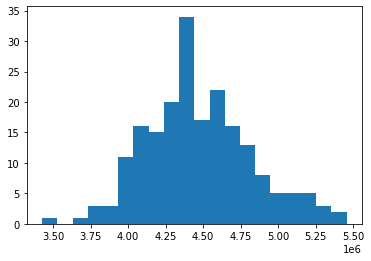

In [7]:
plt.hist(scores, bins=20)
plt.show()

In [8]:
# ここでエラー出力は何かおかしいかもしれない


# パラメータ抽出
with open(FILENAME) as f:
    answer = f.read()


variables_optimize = []

for left, value, right, options in re.findall(r"^([^/\n]*=\s*)(.+?)(\s*;\s*//(?:.*\W)?OPTIMIZE(\W.*))$", answer, re.MULTILINE):
    name = left.replace("=", "").strip().split()[-1]
    
    searched = re.search(r".*\[(?P<min>.*),(?P<max>.*)\].*", options)
    if searched:
        min_value = max_value = None
        try:
            min_value = eval(searched.group("min"))
            max_value = eval(searched.group("max"))
            assert min_value <= max_value
        except Exception as e:
            print(f"searched={searched}", file=sys.stderr)
            print(e, file=sys.stderr)
            continue
        log = "LOG" in options  # 雑、直したほうが良い
        if type(min_value) != type(max_value):
            print(f"searched={searched}", file=sys.stderr)
            print("types not matched", file=sys.stderr)
            continue
        if isinstance(min_value, int):
            method = "suggest_int"
        elif isinstance(min_value, float):
            method = "suggest_float"
        else:
            print(f"searched={searched}", file=sys.stderr)
            print(f"unknown type ({type(min_value)})", file=sys.stderr)
            continue
        variables_optimize.append({
            "name": name,
            "method": method,
            "min": min_value,
            "max": max_value,
            "log": log,
            "left": left,
            "right": right,
        })
    elif searched := re.search(r".*\{(?P<choices>.*?)\}.*", options):
        choices = list(map(lambda x: x.strip(), searched.group("choices").split(",")))
        variables_optimize.append({
            "name": name,
            "method": "suggest_categorical",
            "choices": choices,
            "left": left,
            "right": right,
        })
    else:
        print(f"searched={searched}", file=sys.stderr)
        print(f"pattern was matched but options are incorrect.", file=sys.stderr)

print(len(variables_optimize), "variables were found.")
if globals().get("pd"):
    display(pd.DataFrame(variables_optimize))
else:
    pprint(variables_optimize)

5 variables were found.


,name,method,min,max,log,left,right,choices
0,K_START,suggest_float,0.020,0.060,True,constexpr double K_START =,"; // OPTIMIZE [0.02, 0.06] LOG",NaN
1,K_END,suggest_float,0.010,0.050,True,constexpr double K_END =,"; // OPTIMIZE [0.01, 0.05] LOG",NaN
2,K_H,suggest_float,0.001,0.999,False,constexpr double K_H =,"; // OPTIMIZE [0.001, 0.999]",NaN
3,PURCHASE_TURN_LIMIT,suggest_int,780.000,880.000,False,constexpr short PURCHASE_TURN_LIMIT =,"; // OPTIMIZE [780, 880]",NaN
4,ROUGH_HASH,suggest_categorical,NaN,NaN,NaN,constexpr int ROUGH_HASH =,"; // OPTIMIZE {0, 0b00000001, 0b00010001, 0b0...","[0, 0b00000001, 0b00010001, 0b00010011, 0b0011..."


In [9]:
def escape(string):  # 正規表現の中でそのまま使いたい文字列をエスケープ
    res = !echo '{string}' | sed -e 's/[]\/$*.^[]/\\&/g'
    return res[0]

def escape_sed(string):  # sed の置換後の文字列用のエスケープ
    res = !echo '{string}' | sed -e 's/[\/&]/\\&/g'
    return res[0]


def objective_with_index(trial, n_internal_parallel):
    index_parallel = trial.number % 12  # これ変数にする
    print(f"{index_parallel=}")
    
    parameters_changed_filename = f"{index_parallel}_{FILENAME}"
    #directory_input = "./in"  # "/" をつけない  # 中のすべてのファイルに対して実行される
    
    !mkdir {index_parallel}_out 2> /dev/null
    !mkdir {index_parallel}_score 2> /dev/null
    !rm {index_parallel}_out/*
    !rm {index_parallel}_score/*
    
    # ファイル作成
    !cp {FILENAME} {parameters_changed_filename}
    sed_options = [f"-i {parameters_changed_filename}"]
    for variable in variables_optimize:
        if variable["method"] == "suggest_categorical":
            val =  trial.suggest_categorical(variable["name"], variable["choices"])
        else:
            val = getattr(trial, variable["method"])(variable["name"], variable["min"], variable["max"], log=variable["log"])
        left = variable["left"]
        right = variable["right"]
        sed_options.append(f"""-e 's/^{escape(left)}.*{escape(right)}$/{escape_sed(left)}{val}{escape_sed(right)}/'""")
    command_sed = f"sed {' '.join(sed_options)}"
    print(command_sed)
    !{command_sed}
    
    # コンパイル
    command_compile = f"g++ {parameters_changed_filename} -std=gnu++17 -O2 -DONLINE_JUDGE -o {parameters_changed_filename}.out 2> /dev/null"
    print(command_compile)
    !{command_compile}
    
    # 実行・採点コマンド (@ はファイル名)
    command_exec = (
        f"./{parameters_changed_filename}.out < {TESTCASE_DIRECTORY}@ >./{index_parallel}_out/@ 2> /dev/null;"
        f"python3 ../A/tester/judge.py {TESTCASE_DIRECTORY}@ ./{index_parallel}_out/@ > ./{index_parallel}_score/@"
        
        #f"cargo run --release --manifest-path ../tools/Cargo.toml --bin tester {directory_input}/@ $(pwd)/{parameters_changed_filename}.out 2>&1 | grep Score | sed -E s/[^0-9]+// > ./{index_parallel}_score/@;"
        
        #f"./{parameters_changed_filename}.out < {directory_input}/@ > ./{index_parallel}_out/@;"
        #f"cargo run --release --manifest-path ./tools/Cargo.toml --bin vis {directory_input}/@ ./{index_parallel}_out/@ 2> /dev/null > ./{index_parallel}_score/@;"
    )
    
    # 並列実行 (sed はパスのディレクトリ部分を消してファイル名にしてる)
    !find {TESTCASE_DIRECTORY}/* | sed 's!^.*/!!' | xargs -I@ -P {n_internal_parallel} sh -c '{command_exec}'
    
    # 集計
    file_paths = !find ./{index_parallel}_score/*
    sum_score = 0
    for file_path in file_paths:  
        with open(file_path) as f:
            sum_score += int(f.read().split(":")[-1])
    return sum_score

In [ ]:
storage_path = f"study.db"
storage = f"sqlite:///{storage_path}"
study_name = "study"
study = optuna.create_study(storage=storage, load_if_exists=True, study_name=study_name, direction="maximize")

def callback(study, trial):
    try:
        if study.best_value == trial.value:
            print(f"Updated! {study.best_value}")
            index_parallel = trial.number % 12
            parameters_changed_filename = f"{index_parallel}_{FILENAME}"
            !cp {parameters_changed_filename} 00000optimized.cpp
        print("callback ok")
    except:
        print(":(")

objective = partial(objective_with_index, n_internal_parallel=4)
study.optimize(objective, n_trials=3000, timeout=86400, n_jobs=1, callbacks=[callback])

[I 2021-09-10 03:54:06,105] A new study created in RDB with name: study


index_parallel=0
rm: cannot remove '0_out/*': No such file or directory
rm: cannot remove '0_score/*': No such file or directory
sed -i 0_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.051655456859383726;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.03137193354027786;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7918522970262206;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 866;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int ROUGH_HASH = .*;  \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010011;  \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}/'
g++ 0_main.cpp -std=gnu++

[I 2021-09-10 03:57:21,978] Trial 0 finished with value: 861024185.0 and parameters: {'K_START': 0.051655456859383726, 'K_END': 0.03137193354027786, 'K_H': 0.7918522970262206, 'PURCHASE_TURN_LIMIT': 866, 'ROUGH_HASH': '0b00010011'}. Best is trial 0 with value: 861024185.0.


Updated! 861024185.0
callback ok
index_parallel=1
rm: cannot remove '1_out/*': No such file or directory
rm: cannot remove '1_score/*': No such file or directory
sed -i 1_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.021373241836791016;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.03811451345184771;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.719911121306159;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 812;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int ROUGH_HASH = .*;  \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;  \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}/'
g+

[I 2021-09-10 04:00:50,119] Trial 1 finished with value: 888938781.0 and parameters: {'K_START': 0.021373241836791016, 'K_END': 0.03811451345184771, 'K_H': 0.719911121306159, 'PURCHASE_TURN_LIMIT': 812, 'ROUGH_HASH': '0'}. Best is trial 1 with value: 888938781.0.


Updated! 888938781.0
callback ok
index_parallel=2
rm: cannot remove '2_out/*': No such file or directory
rm: cannot remove '2_score/*': No such file or directory
sed -i 2_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.0401108650028289;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.014382848512132054;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.5360572623179805;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 814;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int ROUGH_HASH = .*;  \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00110011;  \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110

[I 2021-09-10 04:03:34,514] Trial 2 finished with value: 801827760.0 and parameters: {'K_START': 0.0401108650028289, 'K_END': 0.014382848512132054, 'K_H': 0.5360572623179805, 'PURCHASE_TURN_LIMIT': 814, 'ROUGH_HASH': '0b00110011'}. Best is trial 1 with value: 888938781.0.


callback ok
index_parallel=3
rm: cannot remove '3_out/*': No such file or directory
rm: cannot remove '3_score/*': No such file or directory
sed -i 3_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.021434266047383573;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04438827657447736;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6985290016549757;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 804;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int ROUGH_HASH = .*;  \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010001;  \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}/'
g++ 3_main.cp

[I 2021-09-10 04:06:46,897] Trial 3 finished with value: 886101580.0 and parameters: {'K_START': 0.021434266047383573, 'K_END': 0.04438827657447736, 'K_H': 0.6985290016549757, 'PURCHASE_TURN_LIMIT': 804, 'ROUGH_HASH': '0b00010001'}. Best is trial 1 with value: 888938781.0.


callback ok
index_parallel=4
rm: cannot remove '4_out/*': No such file or directory
rm: cannot remove '4_score/*': No such file or directory
sed -i 4_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.04337151218687437;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.034980887170792195;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9545333962729241;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 788;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int ROUGH_HASH = .*;  \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;  \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}/'
g++ 4_main.cpp -std=gn

[I 2021-09-10 04:10:09,901] Trial 4 finished with value: 867428098.0 and parameters: {'K_START': 0.04337151218687437, 'K_END': 0.034980887170792195, 'K_H': 0.9545333962729241, 'PURCHASE_TURN_LIMIT': 788, 'ROUGH_HASH': '0'}. Best is trial 1 with value: 888938781.0.


callback ok
index_parallel=5
rm: cannot remove '5_out/*': No such file or directory
rm: cannot remove '5_score/*': No such file or directory
sed -i 5_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.045108869250615025;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04624355390380819;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.3001303275900002;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 807;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int ROUGH_HASH = .*;  \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;  \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}/'
g++ 5_main.cp

[I 2021-09-10 04:13:30,508] Trial 5 finished with value: 727928543.0 and parameters: {'K_START': 0.045108869250615025, 'K_END': 0.04624355390380819, 'K_H': 0.3001303275900002, 'PURCHASE_TURN_LIMIT': 807, 'ROUGH_HASH': '0b00000001'}. Best is trial 1 with value: 888938781.0.


callback ok
index_parallel=6
rm: cannot remove '6_out/*': No such file or directory
rm: cannot remove '6_score/*': No such file or directory
sed -i 6_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.023960756179581644;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.037502029462947235;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8444496866362601;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 848;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int ROUGH_HASH = .*;  \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010001;  \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}/'
g++ 6_main.c

[I 2021-09-10 04:16:52,535] Trial 6 finished with value: 883882934.0 and parameters: {'K_START': 0.023960756179581644, 'K_END': 0.037502029462947235, 'K_H': 0.8444496866362601, 'PURCHASE_TURN_LIMIT': 848, 'ROUGH_HASH': '0b00010001'}. Best is trial 1 with value: 888938781.0.


callback ok
index_parallel=7
rm: cannot remove '7_out/*': No such file or directory
rm: cannot remove '7_score/*': No such file or directory
sed -i 7_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.020834945299122807;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.023338977505482576;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.27108834494101264;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 879;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int ROUGH_HASH = .*;  \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;  \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}/'
g++ 7_main.

[I 2021-09-10 04:20:29,889] Trial 7 finished with value: 821703982.0 and parameters: {'K_START': 0.020834945299122807, 'K_END': 0.023338977505482576, 'K_H': 0.27108834494101264, 'PURCHASE_TURN_LIMIT': 879, 'ROUGH_HASH': '0b00000001'}. Best is trial 1 with value: 888938781.0.


callback ok
index_parallel=8
rm: cannot remove '8_out/*': No such file or directory
rm: cannot remove '8_score/*': No such file or directory
sed -i 8_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.05488879497921039;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.018746131446544488;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.009293428962473326;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 782;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int ROUGH_HASH = .*;  \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00110011;  \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}/'
g++ 8_main.

[I 2021-09-10 04:23:19,411] Trial 8 finished with value: 358171867.0 and parameters: {'K_START': 0.05488879497921039, 'K_END': 0.018746131446544488, 'K_H': 0.009293428962473326, 'PURCHASE_TURN_LIMIT': 782, 'ROUGH_HASH': '0b00110011'}. Best is trial 1 with value: 888938781.0.


callback ok
index_parallel=9
rm: cannot remove '9_out/*': No such file or directory
rm: cannot remove '9_score/*': No such file or directory
sed -i 9_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.046729021408715044;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04704861203847925;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6188217229307872;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 823;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int ROUGH_HASH = .*;  \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00110011;  \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}/'
g++ 9_main.cp

[I 2021-09-10 04:26:17,025] Trial 9 finished with value: 605999091.0 and parameters: {'K_START': 0.046729021408715044, 'K_END': 0.04704861203847925, 'K_H': 0.6188217229307872, 'PURCHASE_TURN_LIMIT': 823, 'ROUGH_HASH': '0b00110011'}. Best is trial 1 with value: 888938781.0.


callback ok
index_parallel=10
rm: cannot remove '10_out/*': No such file or directory
rm: cannot remove '10_score/*': No such file or directory
sed -i 10_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.03062444938194489;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.010268122075022677;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.37571020446986714;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 842;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int ROUGH_HASH = .*;  \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;  \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}/'
g++ 10_main.cpp -

[I 2021-09-10 04:29:43,107] Trial 10 finished with value: 809211781.0 and parameters: {'K_START': 0.03062444938194489, 'K_END': 0.010268122075022677, 'K_H': 0.37571020446986714, 'PURCHASE_TURN_LIMIT': 842, 'ROUGH_HASH': '0'}. Best is trial 1 with value: 888938781.0.


callback ok
index_parallel=11
rm: cannot remove '11_out/*': No such file or directory
rm: cannot remove '11_score/*': No such file or directory
sed -i 11_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.02702180050529103;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.026499807571107602;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.686158799163983;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 798;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int ROUGH_HASH = .*;  \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010001;  \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}/'
g++ 11_mai

[I 2021-09-10 04:32:56,635] Trial 11 finished with value: 845601125.0 and parameters: {'K_START': 0.02702180050529103, 'K_END': 0.026499807571107602, 'K_H': 0.686158799163983, 'PURCHASE_TURN_LIMIT': 798, 'ROUGH_HASH': '0b00010001'}. Best is trial 1 with value: 888938781.0.


callback ok
index_parallel=0
sed -i 0_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.020377386452152316;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.047040402734174265;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7661694419128214;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 829;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int ROUGH_HASH = .*;  \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;  \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}/'
g++ 0_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 0_main.cpp.out 2> /dev/null


[I 2021-09-10 04:36:22,846] Trial 12 finished with value: 906189916.0 and parameters: {'K_START': 0.020377386452152316, 'K_END': 0.047040402734174265, 'K_H': 0.7661694419128214, 'PURCHASE_TURN_LIMIT': 829, 'ROUGH_HASH': '0'}. Best is trial 12 with value: 906189916.0.


Updated! 906189916.0
callback ok
index_parallel=1
sed -i 1_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.032244918094540505;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.029799960014841732;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9536591254336516;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 831;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int ROUGH_HASH = .*;  \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;  \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}/'
g++ 1_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 1_main.cpp.out 2> /dev/null


[I 2021-09-10 04:39:53,706] Trial 13 finished with value: 879760800.0 and parameters: {'K_START': 0.032244918094540505, 'K_END': 0.029799960014841732, 'K_H': 0.9536591254336516, 'PURCHASE_TURN_LIMIT': 831, 'ROUGH_HASH': '0'}. Best is trial 12 with value: 906189916.0.


callback ok
index_parallel=2
sed -i 2_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.026046928406627538;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.03820276197869667;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.5030455728882653;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 829;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int ROUGH_HASH = .*;  \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;  \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}/'
g++ 2_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 2_main.cpp.out 2> /dev/null


[I 2021-09-10 04:43:27,806] Trial 14 finished with value: 893650492.0 and parameters: {'K_START': 0.026046928406627538, 'K_END': 0.03820276197869667, 'K_H': 0.5030455728882653, 'PURCHASE_TURN_LIMIT': 829, 'ROUGH_HASH': '0'}. Best is trial 12 with value: 906189916.0.


callback ok
index_parallel=3
sed -i 3_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.02666837017119146;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.01924895852771756;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.43013964176131747;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 845;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int ROUGH_HASH = .*;  \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;  \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}/'
g++ 3_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 3_main.cpp.out 2> /dev/null


[I 2021-09-10 04:46:58,336] Trial 15 finished with value: 848147915.0 and parameters: {'K_START': 0.02666837017119146, 'K_END': 0.01924895852771756, 'K_H': 0.43013964176131747, 'PURCHASE_TURN_LIMIT': 845, 'ROUGH_HASH': '0'}. Best is trial 12 with value: 906189916.0.


callback ok
index_parallel=4
sed -i 4_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.02492367362173285;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04903461052482631;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.5371896572435119;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 830;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int ROUGH_HASH = .*;  \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010011;  \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}/'
g++ 4_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 4_main.cpp.out 2> /dev/null


[I 2021-09-10 04:49:58,326] Trial 16 finished with value: 897834714.0 and parameters: {'K_START': 0.02492367362173285, 'K_END': 0.04903461052482631, 'K_H': 0.5371896572435119, 'PURCHASE_TURN_LIMIT': 830, 'ROUGH_HASH': '0b00010011'}. Best is trial 12 with value: 906189916.0.


callback ok
index_parallel=5
sed -i 5_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.03500026940219137;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.049894152193554205;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.14570900921447666;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 840;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int ROUGH_HASH = .*;  \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010011;  \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}/'
g++ 5_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 5_main.cpp.out 2> /dev/null


[I 2021-09-10 04:53:02,911] Trial 17 finished with value: 894284407.0 and parameters: {'K_START': 0.03500026940219137, 'K_END': 0.049894152193554205, 'K_H': 0.14570900921447666, 'PURCHASE_TURN_LIMIT': 840, 'ROUGH_HASH': '0b00010011'}. Best is trial 12 with value: 906189916.0.


callback ok
index_parallel=6
sed -i 6_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.023617061122870212;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.014929287701765017;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.5882963179845726;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 859;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int ROUGH_HASH = .*;  \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010011;  \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}/'
g++ 6_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 6_main.cpp.out 2> /dev/null


[I 2021-09-10 04:56:11,881] Trial 18 finished with value: 802707899.0 and parameters: {'K_START': 0.023617061122870212, 'K_END': 0.014929287701765017, 'K_H': 0.5882963179845726, 'PURCHASE_TURN_LIMIT': 859, 'ROUGH_HASH': '0b00010011'}. Best is trial 12 with value: 906189916.0.


callback ok
index_parallel=7
sed -i 7_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.029633392456137535;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.026765392582636115;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8375888033002623;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 825;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int ROUGH_HASH = .*;  \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010011;  \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}/'
g++ 7_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 7_main.cpp.out 2> /dev/null


[I 2021-09-10 04:59:24,443] Trial 19 finished with value: 860706787.0 and parameters: {'K_START': 0.029633392456137535, 'K_END': 0.026765392582636115, 'K_H': 0.8375888033002623, 'PURCHASE_TURN_LIMIT': 825, 'ROUGH_HASH': '0b00010011'}. Best is trial 12 with value: 906189916.0.


callback ok
index_parallel=8
sed -i 8_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.037248639831061935;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04313927571754842;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.43039717460350696;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 856;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int ROUGH_HASH = .*;  \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010011;  \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}/'
g++ 8_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 8_main.cpp.out 2> /dev/null


[I 2021-09-10 05:02:41,982] Trial 20 finished with value: 885929910.0 and parameters: {'K_START': 0.037248639831061935, 'K_END': 0.04313927571754842, 'K_H': 0.43039717460350696, 'PURCHASE_TURN_LIMIT': 856, 'ROUGH_HASH': '0b00010011'}. Best is trial 12 with value: 906189916.0.


callback ok
index_parallel=9
sed -i 9_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.03554033439720083;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04986949914520282;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.09058010870647698;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 834;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int ROUGH_HASH = .*;  \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010011;  \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}/'
g++ 9_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 9_main.cpp.out 2> /dev/null


[I 2021-09-10 05:05:57,742] Trial 21 finished with value: 892604742.0 and parameters: {'K_START': 0.03554033439720083, 'K_END': 0.04986949914520282, 'K_H': 0.09058010870647698, 'PURCHASE_TURN_LIMIT': 834, 'ROUGH_HASH': '0b00010011'}. Best is trial 12 with value: 906189916.0.


callback ok
index_parallel=10
sed -i 10_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.020167378385701006;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.040560763134086616;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.23831198312249963;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 838;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int ROUGH_HASH = .*;  \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010011;  \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}/'
g++ 10_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 10_main.cpp.out 2> /dev/null


[I 2021-09-10 05:09:14,706] Trial 22 finished with value: 876772039.0 and parameters: {'K_START': 0.020167378385701006, 'K_END': 0.040560763134086616, 'K_H': 0.23831198312249963, 'PURCHASE_TURN_LIMIT': 838, 'ROUGH_HASH': '0b00010011'}. Best is trial 12 with value: 906189916.0.


callback ok
index_parallel=11
sed -i 11_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.023833973746228133;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.049356318168997396;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.1552550203789732;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 816;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int ROUGH_HASH = .*;  \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010011;  \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}/'
g++ 11_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 11_main.cpp.out 2> /dev/null


[I 2021-09-10 05:12:32,342] Trial 23 finished with value: 881588854.0 and parameters: {'K_START': 0.023833973746228133, 'K_END': 0.049356318168997396, 'K_H': 0.1552550203789732, 'PURCHASE_TURN_LIMIT': 816, 'ROUGH_HASH': '0b00010011'}. Best is trial 12 with value: 906189916.0.


callback ok
index_parallel=0
sed -i 0_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.03412912509322803;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.03189431173278296;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.3438782458809477;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 853;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int ROUGH_HASH = .*;  \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010011;  \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}/'
g++ 0_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 0_main.cpp.out 2> /dev/null


[I 2021-09-10 05:15:57,866] Trial 24 finished with value: 876942455.0 and parameters: {'K_START': 0.03412912509322803, 'K_END': 0.03189431173278296, 'K_H': 0.3438782458809477, 'PURCHASE_TURN_LIMIT': 853, 'ROUGH_HASH': '0b00010011'}. Best is trial 12 with value: 906189916.0.


callback ok
index_parallel=1
sed -i 1_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.028516287031398163;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04169081450066162;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.5889724634319348;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 866;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int ROUGH_HASH = .*;  \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;  \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}/'
g++ 1_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 1_main.cpp.out 2> /dev/null


[I 2021-09-10 05:19:49,658] Trial 25 finished with value: 878594843.0 and parameters: {'K_START': 0.028516287031398163, 'K_END': 0.04169081450066162, 'K_H': 0.5889724634319348, 'PURCHASE_TURN_LIMIT': 866, 'ROUGH_HASH': '0b00000001'}. Best is trial 12 with value: 906189916.0.


callback ok
index_parallel=2
sed -i 2_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.02319557092517025;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.035180824615332784;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.1940223153306857;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 823;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int ROUGH_HASH = .*;  \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010011;  \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}/'
g++ 2_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 2_main.cpp.out 2> /dev/null


[I 2021-09-10 05:23:08,597] Trial 26 finished with value: 871459422.0 and parameters: {'K_START': 0.02319557092517025, 'K_END': 0.035180824615332784, 'K_H': 0.1940223153306857, 'PURCHASE_TURN_LIMIT': 823, 'ROUGH_HASH': '0b00010011'}. Best is trial 12 with value: 906189916.0.


callback ok
index_parallel=3
sed -i 3_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.039528051265056506;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04281702168668528;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.44112628582541974;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 835;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int ROUGH_HASH = .*;  \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010011;  \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}/'
g++ 3_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 3_main.cpp.out 2> /dev/null


[I 2021-09-10 05:26:31,730] Trial 27 finished with value: 895703741.0 and parameters: {'K_START': 0.039528051265056506, 'K_END': 0.04281702168668528, 'K_H': 0.44112628582541974, 'PURCHASE_TURN_LIMIT': 835, 'ROUGH_HASH': '0b00010011'}. Best is trial 12 with value: 906189916.0.


callback ok
index_parallel=4
sed -i 4_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.03876681417331658;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.03393732475793739;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.44142607076602225;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 818;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int ROUGH_HASH = .*;  \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;  \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}/'
g++ 4_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 4_main.cpp.out 2> /dev/null


[I 2021-09-10 05:30:18,703] Trial 28 finished with value: 888811710.0 and parameters: {'K_START': 0.03876681417331658, 'K_END': 0.03393732475793739, 'K_H': 0.44142607076602225, 'PURCHASE_TURN_LIMIT': 818, 'ROUGH_HASH': '0'}. Best is trial 12 with value: 906189916.0.


callback ok
index_parallel=5
sed -i 5_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.04952917785186808;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.028056803832814135;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7723255792104886;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 834;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int ROUGH_HASH = .*;  \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010011;  \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}/'
g++ 5_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 5_main.cpp.out 2> /dev/null


[I 2021-09-10 05:33:41,282] Trial 29 finished with value: 869659548.0 and parameters: {'K_START': 0.04952917785186808, 'K_END': 0.028056803832814135, 'K_H': 0.7723255792104886, 'PURCHASE_TURN_LIMIT': 834, 'ROUGH_HASH': '0b00010011'}. Best is trial 12 with value: 906189916.0.


callback ok
index_parallel=6
sed -i 6_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.057986728052268045;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04190071982879421;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6437621559994487;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 849;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int ROUGH_HASH = .*;  \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;  \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}/'
g++ 6_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 6_main.cpp.out 2> /dev/null


[I 2021-09-10 05:37:29,346] Trial 30 finished with value: 505073478.0 and parameters: {'K_START': 0.057986728052268045, 'K_END': 0.04190071982879421, 'K_H': 0.6437621559994487, 'PURCHASE_TURN_LIMIT': 849, 'ROUGH_HASH': '0b00000001'}. Best is trial 12 with value: 906189916.0.


callback ok
index_parallel=7
sed -i 7_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.041994570256460584;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04919638151928213;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.873761617078423;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 839;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int ROUGH_HASH = .*;  \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010011;  \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}/'
g++ 7_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 7_main.cpp.out 2> /dev/null


[I 2021-09-10 05:40:54,971] Trial 31 finished with value: 572214142.0 and parameters: {'K_START': 0.041994570256460584, 'K_END': 0.04919638151928213, 'K_H': 0.873761617078423, 'PURCHASE_TURN_LIMIT': 839, 'ROUGH_HASH': '0b00010011'}. Best is trial 12 with value: 906189916.0.


callback ok
index_parallel=8
sed -i 8_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.03300970580055568;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.039822494589392056;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7528582474668042;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 828;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int ROUGH_HASH = .*;  \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010011;  \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}/'
g++ 8_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 8_main.cpp.out 2> /dev/null


[I 2021-09-10 05:44:17,266] Trial 32 finished with value: 893240714.0 and parameters: {'K_START': 0.03300970580055568, 'K_END': 0.039822494589392056, 'K_H': 0.7528582474668042, 'PURCHASE_TURN_LIMIT': 828, 'ROUGH_HASH': '0b00010011'}. Best is trial 12 with value: 906189916.0.


callback ok
index_parallel=9
sed -i 9_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.036986844328171356;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.044968109877238434;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.07616909579305274;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 838;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int ROUGH_HASH = .*;  \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010011;  \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}/'
g++ 9_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 9_main.cpp.out 2> /dev/null


[I 2021-09-10 05:47:37,791] Trial 33 finished with value: 893246408.0 and parameters: {'K_START': 0.036986844328171356, 'K_END': 0.044968109877238434, 'K_H': 0.07616909579305274, 'PURCHASE_TURN_LIMIT': 838, 'ROUGH_HASH': '0b00010011'}. Best is trial 12 with value: 906189916.0.


callback ok
index_parallel=10
sed -i 10_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.022073092993718197;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.036636779377485384;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.5332312540106717;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 820;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int ROUGH_HASH = .*;  \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00110011;  \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}/'
g++ 10_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 10_main.cpp.out 2> /dev/null


[I 2021-09-10 05:50:40,534] Trial 34 finished with value: 870396688.0 and parameters: {'K_START': 0.022073092993718197, 'K_END': 0.036636779377485384, 'K_H': 0.5332312540106717, 'PURCHASE_TURN_LIMIT': 820, 'ROUGH_HASH': '0b00110011'}. Best is trial 12 with value: 906189916.0.


callback ok
index_parallel=11
sed -i 11_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.03981030553981549;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04439838988926067;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.3652152259133009;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 809;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int ROUGH_HASH = .*;  \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010001;  \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}/'
g++ 11_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 11_main.cpp.out 2> /dev/null


[I 2021-09-10 05:54:03,545] Trial 35 finished with value: 888730374.0 and parameters: {'K_START': 0.03981030553981549, 'K_END': 0.04439838988926067, 'K_H': 0.3652152259133009, 'PURCHASE_TURN_LIMIT': 809, 'ROUGH_HASH': '0b00010001'}. Best is trial 12 with value: 906189916.0.


callback ok
index_parallel=0
sed -i 0_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.030369790946310246;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.031725961919058306;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.4728754411520557;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 798;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int ROUGH_HASH = .*;  \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010011;  \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}/'
g++ 0_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 0_main.cpp.out 2> /dev/null


[I 2021-09-10 05:57:16,680] Trial 36 finished with value: 860150328.0 and parameters: {'K_START': 0.030369790946310246, 'K_END': 0.031725961919058306, 'K_H': 0.4728754411520557, 'PURCHASE_TURN_LIMIT': 798, 'ROUGH_HASH': '0b00010011'}. Best is trial 12 with value: 906189916.0.


callback ok
index_parallel=1
sed -i 1_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.025214426277743396;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04505419804069686;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6790273045695958;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 842;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int ROUGH_HASH = .*;  \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;  \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}/'
g++ 1_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 1_main.cpp.out 2> /dev/null


[I 2021-09-10 06:01:03,530] Trial 37 finished with value: 900571749.0 and parameters: {'K_START': 0.025214426277743396, 'K_END': 0.04505419804069686, 'K_H': 0.6790273045695958, 'PURCHASE_TURN_LIMIT': 842, 'ROUGH_HASH': '0'}. Best is trial 12 with value: 906189916.0.


callback ok
index_parallel=2
sed -i 2_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.024944571727669337;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.03376060937297182;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7032660855389088;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 850;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int ROUGH_HASH = .*;  \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;  \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}/'
g++ 2_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 2_main.cpp.out 2> /dev/null


[I 2021-09-10 06:04:42,772] Trial 38 finished with value: 884244131.0 and parameters: {'K_START': 0.024944571727669337, 'K_END': 0.03376060937297182, 'K_H': 0.7032660855389088, 'PURCHASE_TURN_LIMIT': 850, 'ROUGH_HASH': '0'}. Best is trial 12 with value: 906189916.0.


callback ok
index_parallel=3
sed -i 3_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.02247740405416075;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.03913289162950407;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.5701278887819714;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 862;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int ROUGH_HASH = .*;  \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;  \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}/'
g++ 3_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 3_main.cpp.out 2> /dev/null


[I 2021-09-10 06:08:29,132] Trial 39 finished with value: 875233719.0 and parameters: {'K_START': 0.02247740405416075, 'K_END': 0.03913289162950407, 'K_H': 0.5701278887819714, 'PURCHASE_TURN_LIMIT': 862, 'ROUGH_HASH': '0'}. Best is trial 12 with value: 906189916.0.


callback ok
index_parallel=4
sed -i 4_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.021358385217528766;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.02226342822595355;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6469162545832062;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 811;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int ROUGH_HASH = .*;  \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;  \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}/'
g++ 4_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 4_main.cpp.out 2> /dev/null


[I 2021-09-10 06:12:00,909] Trial 40 finished with value: 843815421.0 and parameters: {'K_START': 0.021358385217528766, 'K_END': 0.02226342822595355, 'K_H': 0.6469162545832062, 'PURCHASE_TURN_LIMIT': 811, 'ROUGH_HASH': '0'}. Best is trial 12 with value: 906189916.0.


callback ok
index_parallel=5
sed -i 5_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.027906077215634588;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04633136591194571;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8892410156730203;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 840;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int ROUGH_HASH = .*;  \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;  \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}/'
g++ 5_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 5_main.cpp.out 2> /dev/null


[I 2021-09-10 06:15:43,583] Trial 41 finished with value: 891294316.0 and parameters: {'K_START': 0.027906077215634588, 'K_END': 0.04633136591194571, 'K_H': 0.8892410156730203, 'PURCHASE_TURN_LIMIT': 840, 'ROUGH_HASH': '0'}. Best is trial 12 with value: 906189916.0.


callback ok
index_parallel=6
sed -i 6_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.025362167776934768;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.045059725397361014;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7875751691206083;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 844;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int ROUGH_HASH = .*;  \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00110011;  \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}/'
g++ 6_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 6_main.cpp.out 2> /dev/null


[I 2021-09-10 06:18:40,382] Trial 42 finished with value: 886586199.0 and parameters: {'K_START': 0.025362167776934768, 'K_END': 0.045059725397361014, 'K_H': 0.7875751691206083, 'PURCHASE_TURN_LIMIT': 844, 'ROUGH_HASH': '0b00110011'}. Best is trial 12 with value: 906189916.0.


callback ok
index_parallel=7
sed -i 7_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.04199147966710954;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.049239183579488116;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7255915407864917;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 834;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int ROUGH_HASH = .*;  \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010001;  \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}/'
g++ 7_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 7_main.cpp.out 2> /dev/null


[I 2021-09-10 06:22:02,789] Trial 43 finished with value: 643960371.0 and parameters: {'K_START': 0.04199147966710954, 'K_END': 0.049239183579488116, 'K_H': 0.7255915407864917, 'PURCHASE_TURN_LIMIT': 834, 'ROUGH_HASH': '0b00010001'}. Best is trial 12 with value: 906189916.0.


callback ok
index_parallel=8
sed -i 8_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.03203685677209046;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.042920615735798744;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6608119963319703;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 873;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int ROUGH_HASH = .*;  \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;  \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}/'
g++ 8_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 8_main.cpp.out 2> /dev/null


[I 2021-09-10 06:25:52,062] Trial 44 finished with value: 874972552.0 and parameters: {'K_START': 0.03203685677209046, 'K_END': 0.042920615735798744, 'K_H': 0.6608119963319703, 'PURCHASE_TURN_LIMIT': 873, 'ROUGH_HASH': '0'}. Best is trial 12 with value: 906189916.0.


callback ok
index_parallel=9
sed -i 9_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.020566320834219942;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.038417491868407726;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.53542776272268;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 827;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int ROUGH_HASH = .*;  \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;  \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}/'
g++ 9_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 9_main.cpp.out 2> /dev/null


[I 2021-09-10 06:29:27,667] Trial 45 finished with value: 890148611.0 and parameters: {'K_START': 0.020566320834219942, 'K_END': 0.038417491868407726, 'K_H': 0.53542776272268, 'PURCHASE_TURN_LIMIT': 827, 'ROUGH_HASH': '0b00000001'}. Best is trial 12 with value: 906189916.0.


callback ok
index_parallel=10
sed -i 10_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.0463866129134562;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.011101249609746967;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.3042160864242238;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 846;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int ROUGH_HASH = .*;  \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;  \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}/'
g++ 10_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 10_main.cpp.out 2> /dev/null


[I 2021-09-10 06:33:07,946] Trial 46 finished with value: 842063135.0 and parameters: {'K_START': 0.0463866129134562, 'K_END': 0.011101249609746967, 'K_H': 0.3042160864242238, 'PURCHASE_TURN_LIMIT': 846, 'ROUGH_HASH': '0'}. Best is trial 12 with value: 906189916.0.


callback ok
index_parallel=11
sed -i 11_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.035601084295174085;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04619253821648412;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.008612870280126111;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 832;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int ROUGH_HASH = .*;  \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010011;  \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}/'
g++ 11_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 11_main.cpp.out 2> /dev/null


[I 2021-09-10 06:36:17,008] Trial 47 finished with value: 889477056.0 and parameters: {'K_START': 0.035601084295174085, 'K_END': 0.04619253821648412, 'K_H': 0.008612870280126111, 'PURCHASE_TURN_LIMIT': 832, 'ROUGH_HASH': '0b00010011'}. Best is trial 12 with value: 906189916.0.


callback ok
index_parallel=0
sed -i 0_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.02478119202831547;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.03573356835756019;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9959746791742066;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 821;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int ROUGH_HASH = .*;  \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00110011;  \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}/'
g++ 0_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 0_main.cpp.out 2> /dev/null


[I 2021-09-10 06:39:09,039] Trial 48 finished with value: 874149114.0 and parameters: {'K_START': 0.02478119202831547, 'K_END': 0.03573356835756019, 'K_H': 0.9959746791742066, 'PURCHASE_TURN_LIMIT': 821, 'ROUGH_HASH': '0b00110011'}. Best is trial 12 with value: 906189916.0.


callback ok
index_parallel=1
sed -i 1_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.03793219086750834;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.040718040885689456;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8073896059819027;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 837;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int ROUGH_HASH = .*;  \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010001;  \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}/'
g++ 1_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 1_main.cpp.out 2> /dev/null


[I 2021-09-10 06:42:38,525] Trial 49 finished with value: 899903343.0 and parameters: {'K_START': 0.03793219086750834, 'K_END': 0.040718040885689456, 'K_H': 0.8073896059819027, 'PURCHASE_TURN_LIMIT': 837, 'ROUGH_HASH': '0b00010001'}. Best is trial 12 with value: 906189916.0.


callback ok
index_parallel=2
sed -i 2_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.0427583195191865;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04053871554652824;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8256980150360592;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 805;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int ROUGH_HASH = .*;  \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010001;  \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}/'
g++ 2_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 2_main.cpp.out 2> /dev/null


[I 2021-09-10 06:45:51,637] Trial 50 finished with value: 888173468.0 and parameters: {'K_START': 0.0427583195191865, 'K_END': 0.04053871554652824, 'K_H': 0.8256980150360592, 'PURCHASE_TURN_LIMIT': 805, 'ROUGH_HASH': '0b00010001'}. Best is trial 12 with value: 906189916.0.


callback ok
index_parallel=3
sed -i 3_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.03825057192254696;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04342547075112909;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9046812150241018;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int ROUGH_HASH = .*;  \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010001;  \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}/'
g++ 3_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 3_main.cpp.out 2> /dev/null


[I 2021-09-10 06:49:14,081] Trial 51 finished with value: 887593111.0 and parameters: {'K_START': 0.03825057192254696, 'K_END': 0.04342547075112909, 'K_H': 0.9046812150241018, 'PURCHASE_TURN_LIMIT': 836, 'ROUGH_HASH': '0b00010001'}. Best is trial 12 with value: 906189916.0.


callback ok
index_parallel=4
sed -i 4_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.034189857729127;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.04722196261500551;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7281475302052164;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 842;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int ROUGH_HASH = .*;  \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010001;  \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}/'
g++ 4_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 4_main.cpp.out 2> /dev/null


[I 2021-09-10 06:52:37,779] Trial 52 finished with value: 878870091.0 and parameters: {'K_START': 0.034189857729127, 'K_END': 0.04722196261500551, 'K_H': 0.7281475302052164, 'PURCHASE_TURN_LIMIT': 842, 'ROUGH_HASH': '0b00010001'}. Best is trial 12 with value: 906189916.0.


callback ok
index_parallel=5
sed -i 5_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.040260060263822006;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.03761408199463084;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8003018502942253;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 830;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int ROUGH_HASH = .*;  \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010001;  \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}/'
g++ 5_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 5_main.cpp.out 2> /dev/null


[I 2021-09-10 06:55:55,498] Trial 53 finished with value: 896575753.0 and parameters: {'K_START': 0.040260060263822006, 'K_END': 0.03761408199463084, 'K_H': 0.8003018502942253, 'PURCHASE_TURN_LIMIT': 830, 'ROUGH_HASH': '0b00010001'}. Best is trial 12 with value: 906189916.0.


callback ok
index_parallel=6
sed -i 6_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.044844320763263085;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.036877131180158805;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8069328307034332;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 830;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int ROUGH_HASH = .*;  \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010001;  \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}/'
g++ 6_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 6_main.cpp.out 2> /dev/null


[I 2021-09-10 06:59:10,065] Trial 54 finished with value: 893176956.0 and parameters: {'K_START': 0.044844320763263085, 'K_END': 0.036877131180158805, 'K_H': 0.8069328307034332, 'PURCHASE_TURN_LIMIT': 830, 'ROUGH_HASH': '0b00010001'}. Best is trial 12 with value: 906189916.0.


callback ok
index_parallel=7
sed -i 7_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.041013268255389215;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.03856737025146465;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9431868448216628;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 826;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int ROUGH_HASH = .*;  \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010001;  \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}/'
g++ 7_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 7_main.cpp.out 2> /dev/null


[I 2021-09-10 07:02:25,427] Trial 55 finished with value: 891525643.0 and parameters: {'K_START': 0.041013268255389215, 'K_END': 0.03856737025146465, 'K_H': 0.9431868448216628, 'PURCHASE_TURN_LIMIT': 826, 'ROUGH_HASH': '0b00010001'}. Best is trial 12 with value: 906189916.0.


callback ok
index_parallel=8
sed -i 8_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.04909745346197107;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.01636229668357072;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6845928817682423;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 852;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int ROUGH_HASH = .*;  \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010001;  \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}/'
g++ 8_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 8_main.cpp.out 2> /dev/null


[I 2021-09-10 07:05:45,156] Trial 56 finished with value: 831794301.0 and parameters: {'K_START': 0.04909745346197107, 'K_END': 0.01636229668357072, 'K_H': 0.6845928817682423, 'PURCHASE_TURN_LIMIT': 852, 'ROUGH_HASH': '0b00010001'}. Best is trial 12 with value: 906189916.0.


callback ok
index_parallel=9
sed -i 9_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.03651478832094366;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.02970626114364123;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8645516357901203;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 814;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int ROUGH_HASH = .*;  \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010001;  \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}/'
g++ 9_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 9_main.cpp.out 2> /dev/null


[I 2021-09-10 07:09:00,093] Trial 57 finished with value: 871330019.0 and parameters: {'K_START': 0.03651478832094366, 'K_END': 0.02970626114364123, 'K_H': 0.8645516357901203, 'PURCHASE_TURN_LIMIT': 814, 'ROUGH_HASH': '0b00010001'}. Best is trial 12 with value: 906189916.0.


callback ok
index_parallel=10
sed -i 10_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.039586974043630214;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.022078880037355253;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7584071270834815;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 831;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int ROUGH_HASH = .*;  \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;  \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}/'
g++ 10_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 10_main.cpp.out 2> /dev/null


[I 2021-09-10 07:12:35,774] Trial 58 finished with value: 860129810.0 and parameters: {'K_START': 0.039586974043630214, 'K_END': 0.022078880037355253, 'K_H': 0.7584071270834815, 'PURCHASE_TURN_LIMIT': 831, 'ROUGH_HASH': '0'}. Best is trial 12 with value: 906189916.0.


callback ok
index_parallel=11
sed -i 11_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.028692321756125908;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.024780194734977508;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.482748080295636;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 823;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int ROUGH_HASH = .*;  \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010001;  \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}/'
g++ 11_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 11_main.cpp.out 2> /dev/null


[I 2021-09-10 07:15:47,982] Trial 59 finished with value: 863427930.0 and parameters: {'K_START': 0.028692321756125908, 'K_END': 0.024780194734977508, 'K_H': 0.482748080295636, 'PURCHASE_TURN_LIMIT': 823, 'ROUGH_HASH': '0b00010001'}. Best is trial 12 with value: 906189916.0.


callback ok
index_parallel=0
sed -i 0_main.cpp -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.02, 0\.06\] LOG$/constexpr double K_START = 0.031905482424130216;  \/\/ OPTIMIZE [0.02, 0.06] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.01, 0\.05\] LOG$/constexpr double K_END = 0.041425434604829454;   \/\/ OPTIMIZE [0.01, 0.05] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.3951072739585427;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[780, 880\]$/constexpr short PURCHASE_TURN_LIMIT = 846;  \/\/ OPTIMIZE [780, 880]/' -e 's/^constexpr int ROUGH_HASH = .*;  \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;  \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}/'
g++ 0_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 0_main.cpp.out 2> /dev/null
